In [1]:
from datasets import load_dataset, Dataset
import numpy as np
from transformers import AutoTokenizer
import format_yelp
from torch.utils.data import DataLoader
from transformers import AutoModelForSequenceClassification
import evaluate
from torch.optim import AdamW
from transformers import get_scheduler
import torch
from tqdm.auto import tqdm
import pickle

In [2]:
random_seed = 42
valid_size = 1000
batch_size = 16
num_epochs = 5
nstep_eval = 500
labelled_size = 10000

In [3]:
dataset = load_dataset("yelp_review_full")
N = len(dataset['train']['label'])
shuffled_dataset = dataset['train'].shuffle(random_seed)
labelled_dataset = shuffled_dataset.select(range(labelled_size))
unlabelled_dataset = shuffled_dataset.select(range(labelled_size,N-valid_size))
acc_valid_dataset = shuffled_dataset.select(range(N-valid_size,N))

In [4]:
with open('text.pickle','rb') as f:
    pickled = pickle.load(f)

In [5]:
large_model_logits = np.loadtxt('large_model_logits.csv')
large_model_probs = np.exp(large_model_logits)
large_model_probs /= large_model_probs.sum(axis=1, keepdims = True)

In [6]:
tokenizer = AutoTokenizer.from_pretrained("prajjwal1/bert-small")
model = AutoModelForSequenceClassification.from_pretrained("prajjwal1/bert-small", num_labels=5)
max_len = model.config.max_position_embeddings

def tokenize_dataset(dataset, max_len):
    return tokenizer(format_yelp.format_dataset(dataset["text"]), padding="max_length", truncation=True, max_length = max_len)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-small and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
def prepare_dataset(dataset, max_len):
    result = dataset.map(tokenize_dataset, batched = True, fn_kwargs = {'max_len':max_len})
    result = result.remove_columns(["text"])
    result = result.rename_column("label", "labels")
    result.set_format("torch")
    return result

In [8]:
train_dataset = Dataset.from_dict({'text':pickled[valid_size:], 'label':large_model_probs[valid_size:]})
valid_dataset = Dataset.from_dict({'text':pickled[:valid_size], 'label':large_model_probs[:valid_size]})

In [9]:
tk_train_dataset = prepare_dataset(train_dataset, max_len)
tk_valid_dataset = prepare_dataset(valid_dataset, max_len)
tk_acc_valid_dataset = prepare_dataset(acc_valid_dataset, max_len)

Map:   0%|          | 0/638000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [10]:
train_dataloader = DataLoader(tk_train_dataset, shuffle=True, batch_size=batch_size)
eval_dataloader = DataLoader(tk_valid_dataset, batch_size=16*batch_size)
acc_dataloader = DataLoader(tk_acc_valid_dataset, batch_size=16*batch_size)

In [11]:
optimizer = AdamW(model.parameters(), lr=2e-5)

num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=num_training_steps//10, num_training_steps=num_training_steps
)


device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 512, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(2, 512)
      (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-3): 4 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=512, out_features=512, bias=True)
              (key): Linear(in_features=512, out_features=512, bias=True)
              (value): Linear(in_features=512, out_features=512, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=512, out_features=512, bias=True)
              (LayerNorm): LayerNorm((512,), eps=1e-12, e

In [12]:
progress_bar = tqdm(range(num_training_steps))

#model.train()
best_ce = np.inf
ces = []
accs = []
step = 0
metric = evaluate.load("accuracy")
model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        #model.train()
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
            
        progress_bar.update(1)
        step += 1
        if step == nstep_eval:
            model.eval()
            loss_eval = []
            for batch in eval_dataloader:
                batch = {k: v.to(device) for k, v in batch.items()}
                with torch.no_grad():
                    outputs = model(**batch)
            
                loss = outputs.loss
                loss_eval.append(loss.item())
            
            ce = np.mean(loss_eval)
            ces.append(ce)
            if ce < best_ce:
                best_ce = ce
                torch.save(model.state_dict(), './distill_checkpoint_small',_use_new_zipfile_serialization=False)
                print(best_ce)
            for batch in acc_dataloader:
                batch = {k: v.to(device) for k, v in batch.items()}
                with torch.no_grad():
                    outputs = model(input_ids = batch['input_ids'], token_type_ids = batch['token_type_ids'], attention_mask = batch['attention_mask'])
            
                logits = outputs.logits
                predictions = torch.argmax(logits, dim=-1)
                metric.add_batch(predictions=predictions, references=batch["labels"])
            
            acc = metric.compute()['accuracy']
            print("accuracy:", acc)
            accs.append(acc)
            model.train()
            step = 0

  0%|          | 0/199375 [00:00<?, ?it/s]

0.5905109196901321
accuracy: 0.185
0.4988212212920189
accuracy: 0.293
0.4671253114938736
accuracy: 0.379
0.42536357790231705
accuracy: 0.42
0.38479945808649063
accuracy: 0.465
0.35764239728450775
accuracy: 0.513
0.32972923666238785
accuracy: 0.532
0.3128492012619972
accuracy: 0.541
0.29394741356372833
accuracy: 0.542
0.2840505838394165
accuracy: 0.561
0.2754830941557884
accuracy: 0.582
0.26443300768733025
accuracy: 0.57
0.257828451693058
accuracy: 0.58
0.25198792666196823
accuracy: 0.588
0.2473289556801319
accuracy: 0.591
accuracy: 0.578
0.24244728311896324
accuracy: 0.583
0.23725678026676178
accuracy: 0.585
0.2319137044250965
accuracy: 0.591
0.2291559837758541
accuracy: 0.588
accuracy: 0.591
0.22780417650938034
accuracy: 0.592
0.22439877316355705
accuracy: 0.592
accuracy: 0.588
0.22295478358864784
accuracy: 0.602
accuracy: 0.595
accuracy: 0.6
accuracy: 0.594
0.22271037474274635
accuracy: 0.586
0.22048450261354446
accuracy: 0.59
0.2204313762485981
accuracy: 0.611
0.21568003296852112
ac

In [13]:
dataset = load_dataset("yelp_review_full")
tk_test_dataset = prepare_dataset(dataset['test'], max_len = max_len)
test_dataloader = DataLoader(tk_test_dataset, batch_size=batch_size)

In [14]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.load_state_dict(torch.load('./distill_checkpoint_small'), strict = True)
model.to(device)
model.eval()
metric = evaluate.load("accuracy")
model_predictions = []
for batch in tqdm(test_dataloader):
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(input_ids = batch['input_ids'], token_type_ids = batch['token_type_ids'], attention_mask = batch['attention_mask'])
            
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        model_predictions.append(predictions.cpu().numpy())
        metric.add_batch(predictions=predictions, references=batch["labels"])
            
acc = metric.compute()['accuracy']

  0%|          | 0/3125 [00:00<?, ?it/s]

In [15]:
acc

0.61494

In [16]:
accs

[0.185,
 0.293,
 0.379,
 0.42,
 0.465,
 0.513,
 0.532,
 0.541,
 0.542,
 0.561,
 0.582,
 0.57,
 0.58,
 0.588,
 0.591,
 0.578,
 0.583,
 0.585,
 0.591,
 0.588,
 0.591,
 0.592,
 0.592,
 0.588,
 0.602,
 0.595,
 0.6,
 0.594,
 0.586,
 0.59,
 0.611,
 0.597,
 0.613,
 0.602,
 0.595,
 0.602,
 0.595,
 0.601,
 0.607,
 0.604,
 0.596,
 0.609,
 0.6,
 0.61,
 0.596,
 0.606,
 0.606,
 0.613,
 0.613,
 0.606,
 0.613,
 0.611,
 0.603,
 0.605,
 0.6,
 0.604,
 0.611,
 0.618,
 0.616,
 0.625,
 0.625,
 0.626,
 0.624,
 0.628,
 0.623,
 0.618,
 0.622,
 0.612,
 0.631,
 0.625,
 0.621,
 0.61,
 0.625,
 0.613,
 0.616,
 0.614,
 0.625,
 0.627,
 0.616,
 0.625,
 0.621,
 0.626,
 0.61,
 0.601,
 0.613,
 0.607,
 0.614,
 0.609,
 0.618,
 0.615,
 0.619,
 0.619,
 0.621,
 0.614,
 0.623,
 0.622,
 0.615,
 0.626,
 0.618,
 0.608,
 0.613,
 0.613,
 0.624,
 0.616,
 0.622,
 0.615,
 0.615,
 0.611,
 0.613,
 0.614,
 0.611,
 0.62,
 0.614,
 0.615,
 0.617,
 0.622,
 0.618,
 0.619,
 0.619,
 0.629,
 0.62,
 0.618,
 0.605,
 0.618,
 0.629,
 0.619,
 0.61,


In [17]:
ces

[0.5905109196901321,
 0.4988212212920189,
 0.4671253114938736,
 0.42536357790231705,
 0.38479945808649063,
 0.35764239728450775,
 0.32972923666238785,
 0.3128492012619972,
 0.29394741356372833,
 0.2840505838394165,
 0.2754830941557884,
 0.26443300768733025,
 0.257828451693058,
 0.25198792666196823,
 0.2473289556801319,
 0.2523087076842785,
 0.24244728311896324,
 0.23725678026676178,
 0.2319137044250965,
 0.2291559837758541,
 0.23387931659817696,
 0.22780417650938034,
 0.22439877316355705,
 0.2297118939459324,
 0.22295478358864784,
 0.22908242046833038,
 0.22431401163339615,
 0.2288881242275238,
 0.22271037474274635,
 0.22048450261354446,
 0.2204313762485981,
 0.21568003296852112,
 0.2180384248495102,
 0.2138163074851036,
 0.2130381502211094,
 0.20899851247668266,
 0.21311402693390846,
 0.2120411992073059,
 0.2165476679801941,
 0.21579081565141678,
 0.20908396318554878,
 0.2112344652414322,
 0.21784049272537231,
 0.21816420927643776,
 0.21926803514361382,
 0.2118358090519905,
 0.2045906

In [18]:
with open('cross_entropy.pickle', 'wb') as f:
    pickle.dump(ces, f)

In [19]:
with open('distilled_small_bert_accs.pickle', 'wb') as f:
    pickle.dump(accs, f)

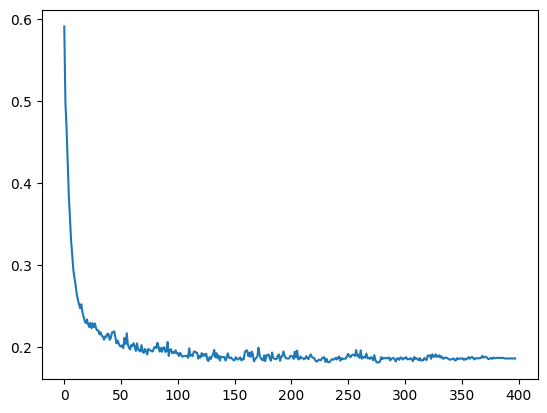

In [20]:
import matplotlib.pyplot as plt
plt.plot(ces)
#plt.yscale("log")

In [21]:
mp = np.array(model_predictions).reshape(-1)

In [22]:
polar_mp = mp.copy()
polar_mp[mp>2] = 4
polar_mp[mp<2] = 0

In [23]:
polar_label = np.array(dataset['test']['label'])
polar_label[polar_label>2] = 4
polar_label[polar_label<2] = 0

In [24]:
np.mean(polar_mp == polar_label)

0.80694

In [25]:
np.mean(np.abs(mp-dataset['test']['label']))

0.4278

In [26]:
def binary_accuracy(logits, labels):
    label_array = np.array(labels)
    binary_index = np.where(label_array != 2)
    probs = np.exp(logits[binary_index])
    probs[:,2] = 0
    probs /= probs.sum(axis=1, keepdims=True)
    binary_pred = (probs[:,3] + probs[:,4])>0.5
    binary_labels = label_array[binary_index]>2
    return np.mean(binary_pred==binary_labels)

In [27]:
model.eval()
metric = evaluate.load("accuracy")
model_predictions = []
model_logits = []
for batch in tqdm(test_dataloader):
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(input_ids = batch['input_ids'], token_type_ids = batch['token_type_ids'], attention_mask = batch['attention_mask'])
            
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        model_predictions.append(predictions.cpu().numpy())
        model_logits.append(logits.cpu().numpy())
        metric.add_batch(predictions=predictions, references=batch["labels"])
            
acc = metric.compute()['accuracy']

  0%|          | 0/3125 [00:00<?, ?it/s]

In [28]:
binary_accuracy(np.vstack(model_logits), dataset['test']['label'])

0.955925